In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'bnw'

In [0]:
def crappifier(fn, i, path):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    img = img.convert('L')
    img.save(dest, quality=60)

In [22]:
il = ImageList.from_folder(path_hr)
parallel(partial(crappifier, path=path_lr), il.items)

For gradual resizing we can change the commented line here.

In [0]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34

## Generator

In [0]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

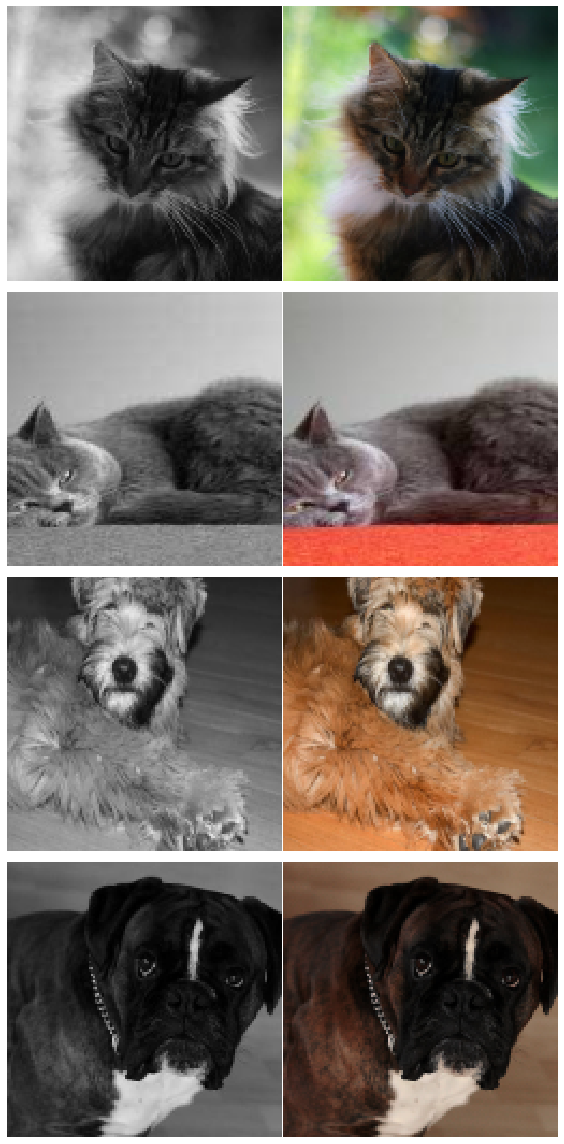

In [27]:
data_gen.show_batch(4)

In [0]:
wd = 1e-3

In [0]:
y_range = (-3.,3.)

In [0]:
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [0]:
learn_gen = create_gen_learner()

In [33]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

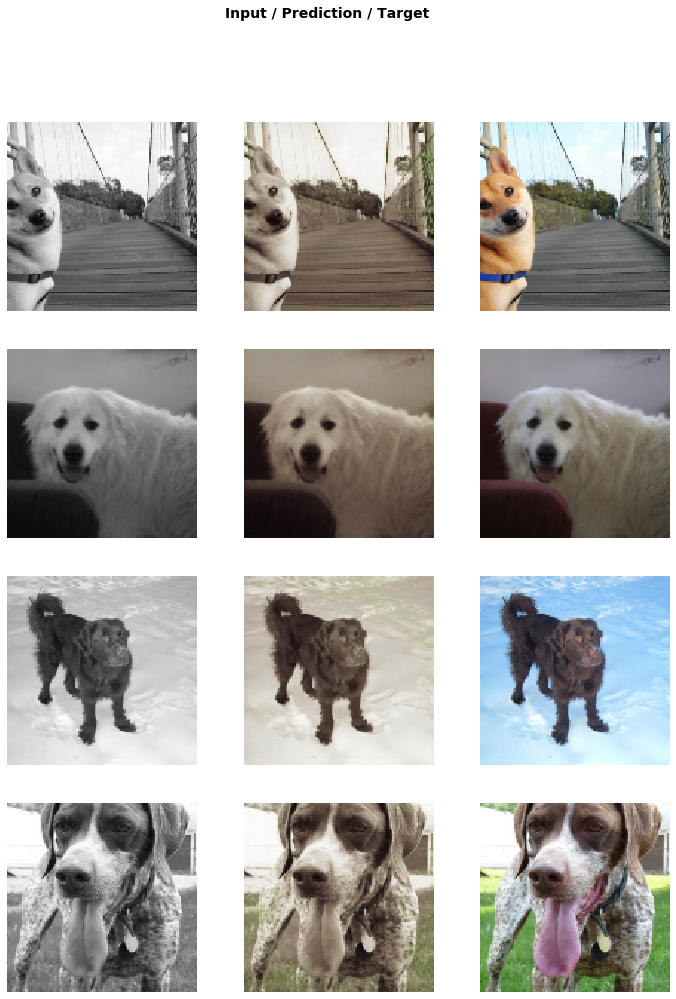

In [34]:
learn_gen.show_results(rows=4)

In [0]:
learn_gen.save('gen-pre2')

In [0]:
learn_gen.load('gen-pre2');

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
# shutil.rmtree(path_gen)

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

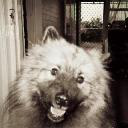

In [41]:
PIL.Image.open(path_gen.ls()[0])

## Critic

In [42]:
learn_gen=None
gc.collect()

19

In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

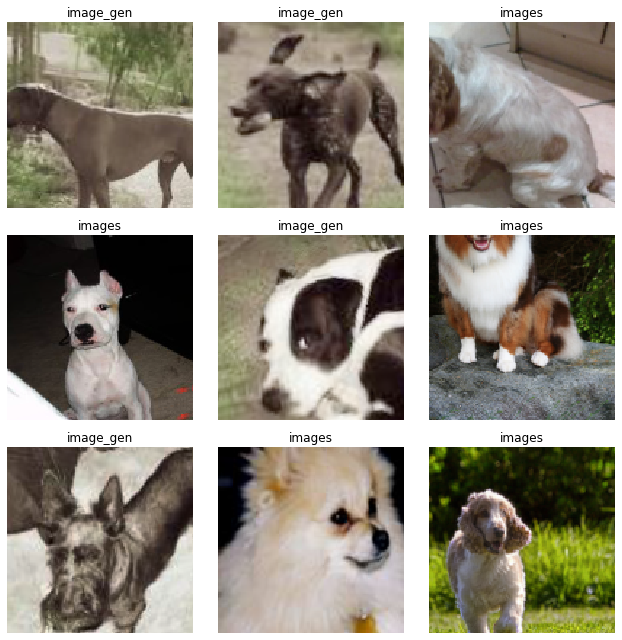

In [45]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [49]:
learn_critic.fit_one_cycle(6, 1e-3)

In [0]:
learn_critic.save('critic-pre2')

## GAN

In [51]:
learn_crit=None
learn_gen=None
gc.collect()

13666

In [0]:
data_crit = get_crit_data(['bnw', 'images'], bs=bs, size=size)

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [0]:
learn_gen = create_gen_learner().load('gen-pre2')

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

In [58]:
learn.fit(10,lr)

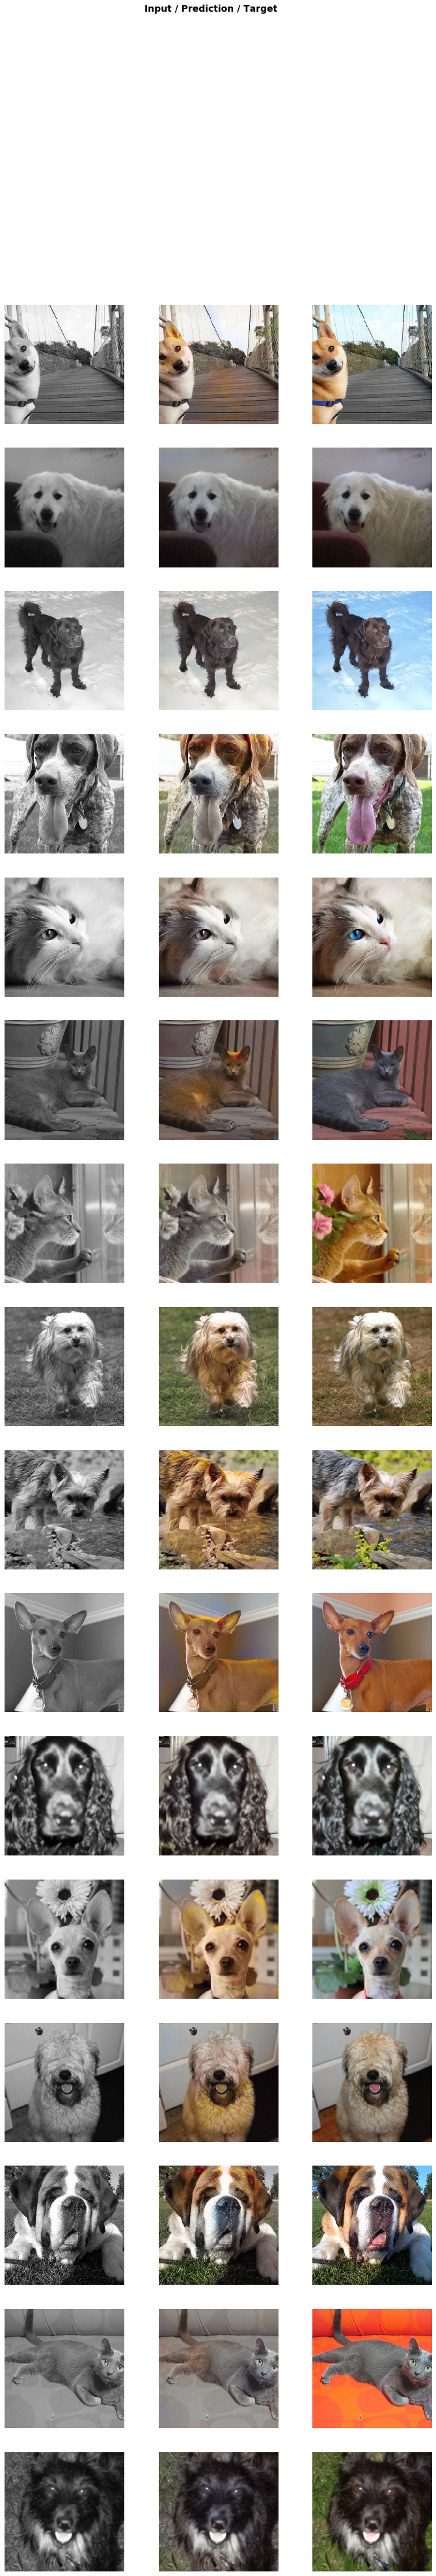

In [59]:
learn.show_results(rows=16)

In [0]:
learn.save('gan-1c')